In [5]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scripts.Training.unsupervised.elbowMethod import plot_inertia_elbow
from scripts.Training.unsupervised.train_evaluate import train_and_evaluate

In [6]:
import pandas as pd

# -----------------------------
# 1. Load your data
# -----------------------------
data_path_32 = "../data/preprocessed/preprocessed_reduced_unsupervised_32.csv"
X_data_32 = pd.read_csv(data_path_32)



data_path_15 = "../data/preprocessed/preprocessed_reduced_unsupervised_15.csv"
X_data_15 = pd.read_csv(data_path_15)



print("Data shape after sampling (k-mean):", X_data_32.shape)
print("Data shape after sampling (dbscan):", X_data_15.shape)

Data shape after sampling (k-mean): (147097, 32)
Data shape after sampling (dbscan): (147097, 15)


Running KMeans for k = 3 to 29...


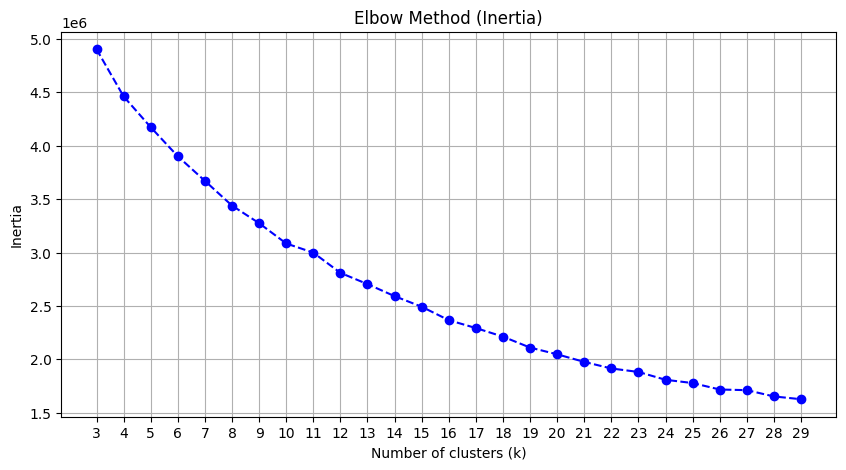

In [9]:
params = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "tol" : 1e-4,
    "random_state": 42
}

k_values = range(3, 30)
inertias = plot_inertia_elbow(X_data_32, k_values, **params)



In [20]:

kmeans_params = {                                                             
    "n_clusters": 20,                           
    "init": "k-means++",                                    
    "n_init": 10,            
    "max_iter": 300,
    "tol" : 1e-4,                   
    "random_state": 42          
}

model, labels, metrics = train_and_evaluate(KMeans, X_data_32, **kmeans_params)




Results for: KMeans
Parameters: {'n_clusters': 20, 'init': 'k-means++', 'n_init': 10, 'max_iter': 300, 'tol': 0.0001, 'random_state': 42}
----------------------------------------
🔹 Silhouette Score:      0.2611 (Close to +1 is best)
🔹 Calinski-Harabasz:     23229.6  (Higher is better)
🔹 Davies-Bouldin:        1.2599 (Lower is better)
🔹 Inertia (SSD):         1038518.5



Calculating K-Distance to find optimal eps...


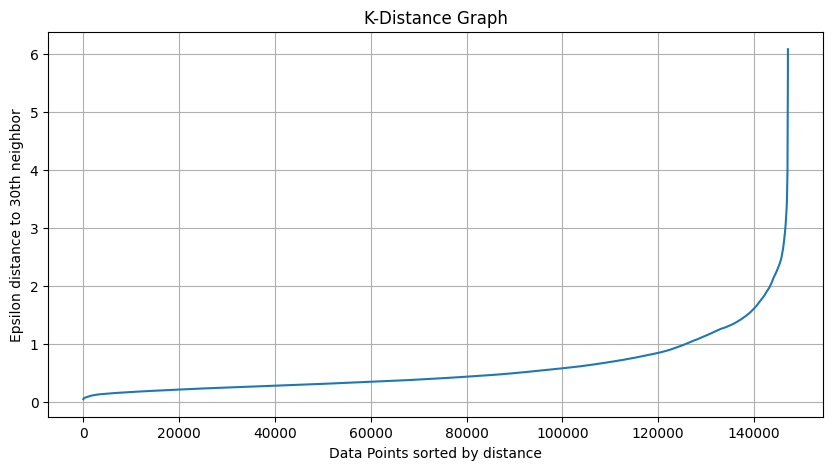

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors




min_samples_val = 30

# B. Finding the optimal 'eps' (The Knee Method)
# We calculate the distance to the (min_samples)-th nearest neighbor for every point.
print("Calculating K-Distance to find optimal eps...")
neighbors = NearestNeighbors(n_neighbors=min_samples_val)
neighbors_fit = neighbors.fit(X_data_15)
distances, indices = neighbors_fit.kneighbors(X_data_15)

# Sort distance values to plot the curve
distances = np.sort(distances[:, min_samples_val-1], axis=0)

# PLOT THE KNEE (Optional but recommended)
# Look for the point of maximum curvature (the "elbow" or "knee").
# The y-axis value at the knee is your optimal 'eps'.
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'Epsilon distance to {min_samples_val}th neighbor')
plt.grid(True)
plt.show()


In [12]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# ==========================================
# DBSCAN fitting (you already have this)
# ==========================================
eps_val = 1.7
min_samples_val = 30  # make sure you have this defined
print(f"Running DBSCAN with eps={eps_val} and min_samples={min_samples_val}...")

db = DBSCAN(eps=eps_val, min_samples=min_samples_val, n_jobs=-1)
labels = db.fit_predict(X_data_15)

# ==========================================
# Results Analysis
# ==========================================
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(f'\nEstimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')
print(f'Percentage of noise: {(n_noise_/len(X_data_15))*100:.2f}%')

# ==========================================
# Metric Evaluation
# ==========================================
# Silhouette Score only makes sense if we have at least 2 clusters
if n_clusters_ > 1:
    # Exclude noise points for silhouette
    mask = labels != -1
    sil_score = silhouette_score(X_data_15[mask], labels[mask])
    db_score = davies_bouldin_score(X_data_15[mask], labels[mask])
    print(f'Silhouette Score (excluding noise): {sil_score:.4f}')
    print(f'Davies-Bouldin Index (excluding noise): {db_score:.4f}')
else:
    print("Not enough clusters to compute Silhouette or Davies-Bouldin scores.")

# Optionally add cluster labels to your dataframe
# df['cluster'] = labels


Running DBSCAN with eps=1.7 and min_samples=30...

Estimated number of clusters: 96
Estimated number of noise points: 3326
Percentage of noise: 2.26%
Silhouette Score (excluding noise): -0.0274
Davies-Bouldin Index (excluding noise): 1.0905
